# K-Nearest Neighbors Analysis
Imports and feature selection

In [1]:
from data_cleaning import ratings_df, watchlist_df, valid_int
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
import SequentialFeatureSelector as SFS #!! Uhhh OHHHh Why are these not working?...
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs


#? Let's get some wrapping feature selection out here woop woop!!
#! Let's do sequential backward selection (SBS)!



## Model Training

In [2]:
X = ratings_df[["IMDb Rating", "Runtime (mins)", "Year", "Num Votes", "Day_Rated"]] 
y = ratings_df['Your Rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
                                            
model = KNeighborsRegressor(n_neighbors=25, weights = "distance") 
model.fit(X_train_scaled, y_train)

KNeighborsRegressor(n_neighbors=25, weights='distance')

## Model Evaluation

In [3]:
y_pred = model.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
print(f'Model 1) \nMean Absolute Error: {round(mae, 3)}')
train_score = model.score(X_train_scaled, y_train)
print(f'Training R-squared: {round(train_score, 3)}')
test_score = model.score(X_test_scaled, y_test)
print(f'Test R-squared: {round(test_score, 3)}', '\n')

print('Model 2) \nMean Absolute Error: 0.927 ') #todo: Change this to whatever is needed!!
print('Test R-squared: 0.298')
print('Training R-squared: 0.263', '\n')
print("Despite model 2 demonstrating better point-wise accuracy with lower MAE, \nI would chose model 1 due to it's superior overall explanatory power reflected in higher R-sqaured scores ")
# print(model.coef_)
# print(model.intercept_) 

Model 1) 
Mean Absolute Error: 0.882
Training R-squared: 1.0
Test R-squared: 0.348 

Model 2) 
Mean Absolute Error: 0.927 
Test R-squared: 0.298
Training R-squared: 0.263 

Despite model 2 demonstrating better point-wise accuracy with lower MAE, 
I would chose model 1 due to it's superior overall explanatory power reflected in higher R-sqaured scores 


## Visualisng Model Performance for different K values

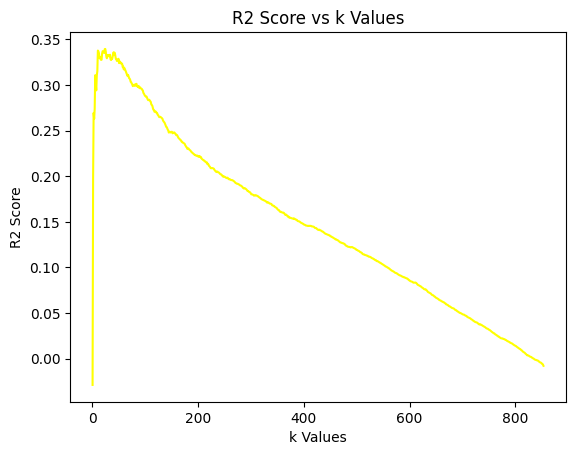

Best k value: 25
Best r2_score: 0.3395


In [4]:

def best_k(training_data, training_labels, test_data, test_labels):
    r2_scores = []

    for k in range(1, len(training_data)):
        model = KNeighborsRegressor(n_neighbors=k)
        model.fit(training_data, training_labels)
        r2_score = model.score(test_data, test_labels)
        r2_scores.append(r2_score)

    
    best_k_value = np.argmax(r2_scores) + 1  # Adding 1 to convert from zero-based index to k value
    best_r2_score = r2_scores[best_k_value - 1]  # Using the best_k_value to get the corresponding r2_score

    return best_k_value, best_r2_score, r2_scores


k_list = range(1, len(X_train_scaled))
best_k_value, best_r2_score, r2_scores2 = best_k(X_train_scaled, y_train, X_test_scaled, y_test) 


plt.plot(k_list, r2_scores2, color="yellow")
plt.xlabel('k Values')
plt.ylabel('R2 Score')
plt.title('R2 Score vs k Values')
plt.show()

print(f"Best k value: {best_k_value}")
print(f"Best r2_score: {round(best_r2_score, 4)}") 

## Predictions on Watchlist

In [5]:
#! Making sure the predictions df lines up with ratings_df
watchlist_df2 = watchlist_df.drop("Title", axis=1).copy()
watchlist_df2 = watchlist_df2[["IMDb Rating", "Runtime (mins)", "Year", "Num Votes", "Day_Rated"]]

# Predictions
watchlist_scaled = scaler.transform(watchlist_df2)
predictions = np.round(model.predict(watchlist_scaled), 1) # Rounded to make it a closer resemblence to acutal IMDb Ratings..

pred_titles = list(zip(watchlist_df['Title'], predictions))
sorted_predictions = sorted(pred_titles, key=lambda x: x[1], reverse=True)

for title, rating in sorted_predictions:
    print(f'{title}: {rating}')

Euphoria: 6.4
The Departed: 6.3
Whiplash: 6.3
The Machinist: 6.1
La La Land: 6.1
The Game: 6.1
Match Point: 6.0
Rogue One: 6.0
Everything Everywhere All at Once: 6.0
Midsommar: 5.9
The Edge of Seventeen: 5.9
The Life of David Gale: 5.9
The Town: 5.9
The Man Who Knew Infinity: 5.8
Ride Like a Girl: 5.6
Magnus: 5.6
Don't Worry Darling: 5.6
Triple Frontier: 5.6
Pawn Sacrifice: 5.6
American Reunion: 5.5
Under the Skin: 5.2
Don't Breathe 2: 5.2
Absolutely Anything: 5.0
Something Borrowed: 5.0
The Place of No Words: 4.6


## User Input Predictions

In [6]:
# Some movies that you can try:
# The Godfather, 9.2, 175, 1972, 2000000
# Napoleon, 6.5, 158, 2023, 95000
# Frozen 2, 6.8, 103, 2019, 191000

def user_predict():
    movie_title = input("Enter the name of the movie/ tv show you would like rated: ")
    imdb_rating = valid_int("Enter the IMDb rating: ", 0, 10)
    runtime = valid_int("Enter the runtime in minutes: ", 0, 250)
    year = valid_int("Enter the year of release: ", 1888, 2024)
    num_votes = valid_int("Enter the number of votes on Imdb: ", 0, 2134288)

    new_data = pd.DataFrame({
        'IMDb Rating': [imdb_rating],
        'Runtime (mins)': [runtime],
        'Year': [year],
        'Num Votes': [num_votes],
        'Day_Rated': [3487] # defaulted as present day : 26/1/24
    })

    new_data_scaled = scaler.transform(new_data)
    predicted_rating = np.round(model.predict(new_data_scaled),1)
    print(f'\nPredicted rating for {movie_title}: {predicted_rating[0]}')

#! user_predict() --------- UNCOMMENT this line to use the predicter function

## Visualisation of Predicted vs Actual Rating

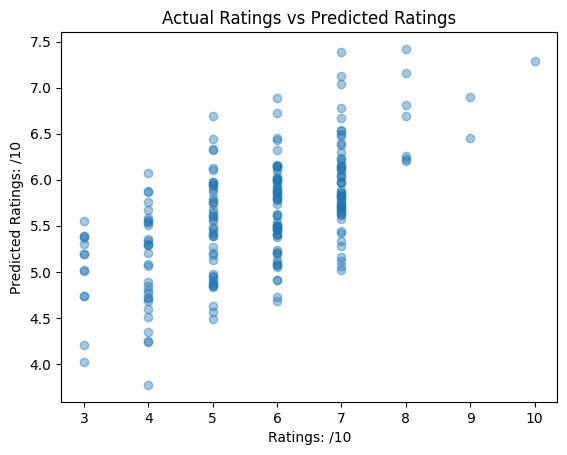

In [7]:
plt.scatter(y_test, y_pred, alpha=0.4)
plt.xlabel("Ratings: /10")
plt.ylabel("Predicted Ratings: /10")
plt.title("Actual Ratings vs Predicted Ratings")
plt.show() 